<a href="https://colab.research.google.com/github/kushv16/Audio-Sentiment-Analysis/blob/master/Dense_Networks_hidden_and_2_layers_on_Combo_of_SAVEE%2C_TESS_and_EMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to avoid TensorFlow compiler flag message

# Importing tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers

include_datasets = ['EmoV_DB', 'SAVEE', 'TESS']

df = pd.read_csv('/content/drive/MyDrive/LY Project/combo.csv')

df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
df['gender'].replace({'female':0,'male':1}, inplace=True)


df.dropna(inplace = True)
df = df[df['dataset'].isin(include_datasets)]

X = df.drop(columns=['path','filename','dataset','duration','age','emotion', 'sample_rate'])
y = df.emotion.values

In [3]:
from sklearn.model_selection import train_test_split

# Create train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y, random_state=0)

# Checking size
print('Shape of X_tr: ', X_tr.shape)
print('Shape of y_tr: ', y_tr.shape)
print('Shape of X_te: ', X_te.shape)
print('Shape of y_te: ', y_te.shape)

Shape of X_tr:  (6421, 90)
Shape of y_tr:  (6421,)
Shape of X_te:  (714, 90)
Shape of y_te:  (714,)


In [4]:
# Scale the data
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [5]:
# Create fully connected model without hidden layers
model = Sequential()

# Output layer with 7 units as for the 7 categories
model.add(Dense(units=7, activation=activations.softmax, input_dim=90, kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))

# Network summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 637       
                                                                 
Total params: 637
Trainable params: 637
Non-trainable params: 0
_________________________________________________________________


In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Computing weights and formatting the output as dictionary
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_tr), y= y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))

# Creates 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Define loss function, optimizer and metrics to track during training
model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])

# Fit model
history = model.fit(
    x=X_tr_rescaled,
    y=y_tr,
    validation_split=0.3,             # Split training/validation sets by 70/30 ratio at each epoch
    class_weight=class_weights,       # Apply class weights
    callbacks=[earlystopping_cb],     # Apply earlystopping callback
    batch_size=32,                    # 32 samples for each batch
    epochs=1000,                       # Running 100 epochs
    shuffle=True,                     # Shuffle training data at each epoch
)


Epoch 1/1000
141/141 [==============================] - 5s 5ms/step - loss: 1.3149 - acc: 0.4838 - val_loss: 1.0258 - val_acc: 0.6430
Epoch 2/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.7429 - acc: 0.7203 - val_loss: 0.7851 - val_acc: 0.7483
Epoch 3/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.6012 - acc: 0.7853 - val_loss: 0.6801 - val_acc: 0.7846
Epoch 4/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.5273 - acc: 0.8140 - val_loss: 0.6124 - val_acc: 0.8168
Epoch 5/1000
141/141 [==============================] - 1s 5ms/step - loss: 0.4801 - acc: 0.8378 - val_loss: 0.5691 - val_acc: 0.8267
Epoch 6/1000
141/141 [==============================] - 1s 5ms/step - loss: 0.4463 - acc: 0.8494 - val_loss: 0.5350 - val_acc: 0.8376
Epoch 7/1000
141/141 [==============================] - 1s 5ms/step - loss: 0.4210 - acc: 0.8576 - val_loss: 0.5081 - val_acc: 0.8433
Epoch 8/1000
141/141 [==============================] - 1s 5ms

In [7]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("/content/drive/MyDrive/LY Project/dense_network_without_hidden_layers_history.csv")

In [8]:
model.save_weights("/content/drive/MyDrive/LY Project/dense_network_without_hidden_layers_weights.h5")

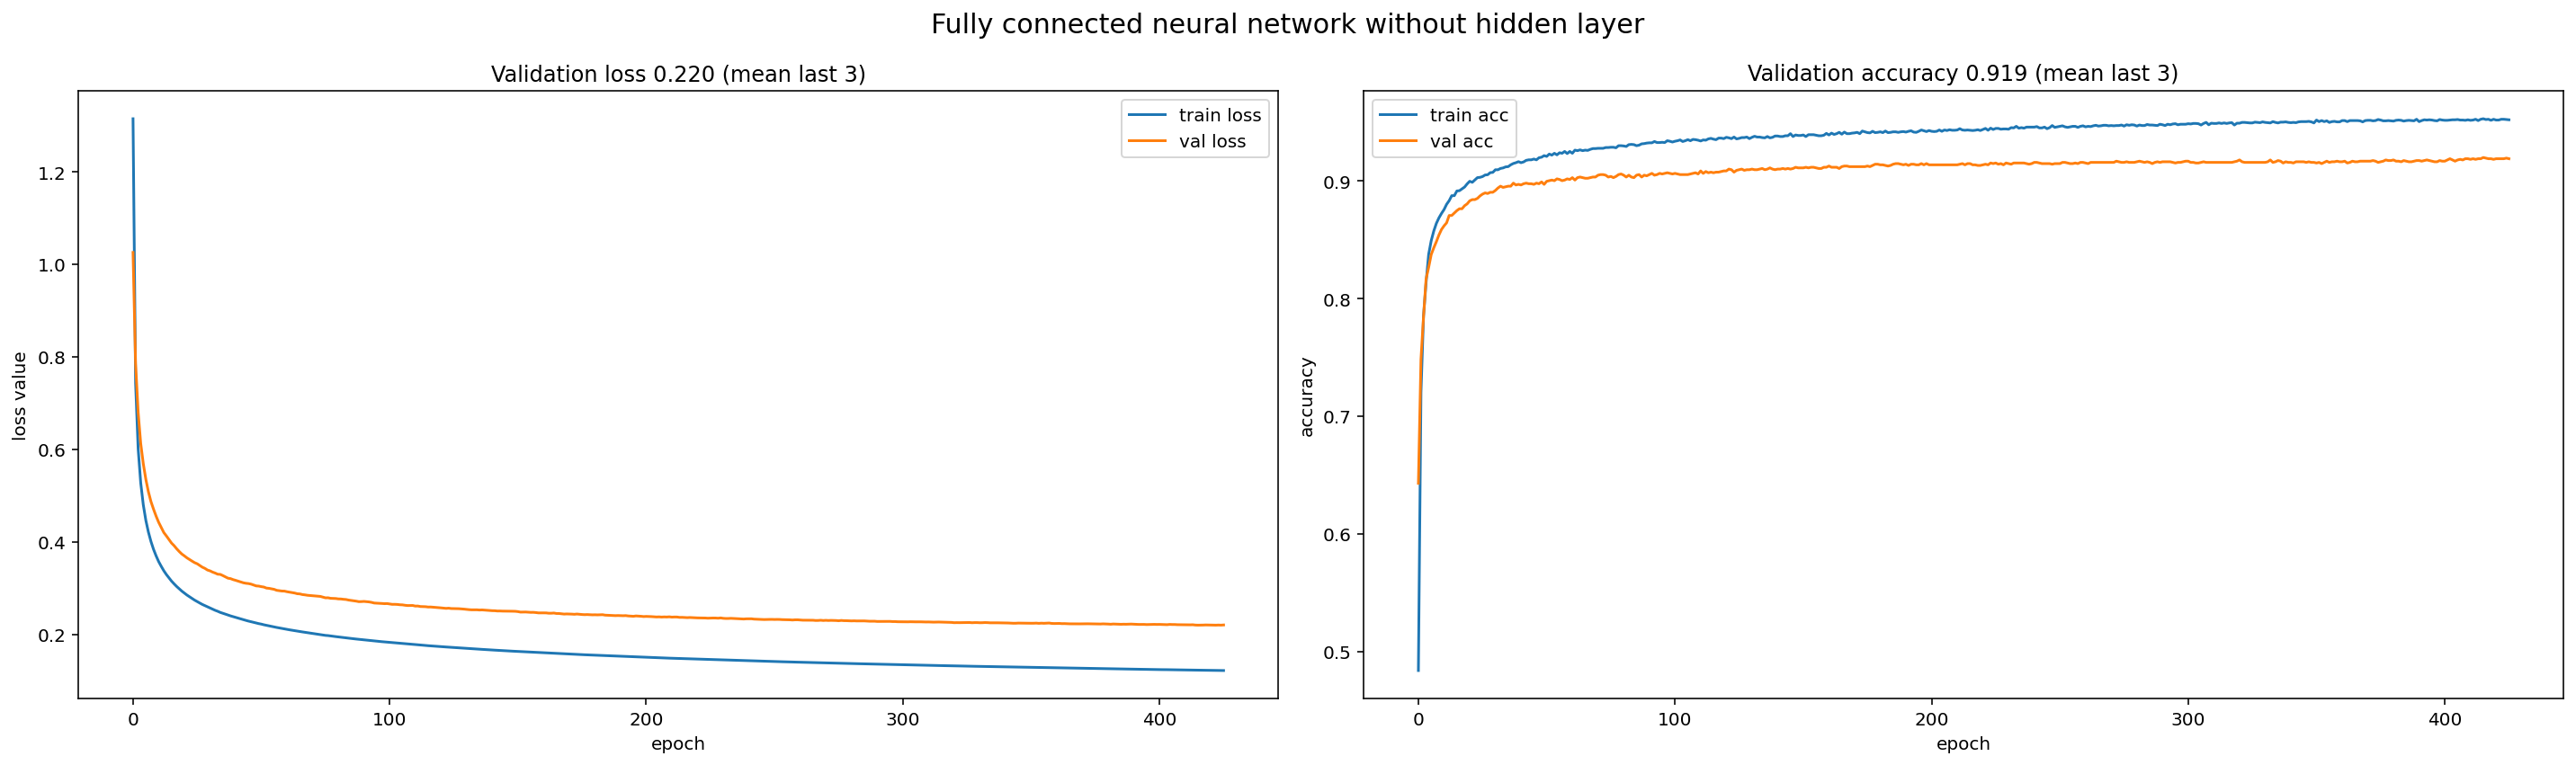

In [9]:
# Import libraries
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.suptitle('Fully connected neural network without hidden layer', size=15)

# Plot loss values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/LY Project/dense_network_without_hidden_layers_training_curves.png")
plt.show()

In [10]:
(test_loss, test_accuracy) = model.evaluate(X_te_rescaled, y_te, batch_size=32)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

23/23 [==============================] - 0s 3ms/step - loss: 0.2272 - acc: 0.9146
Test loss: 0.23
Test accuracy: 91.46%


23/23 [==============================] - 0s 2ms/step


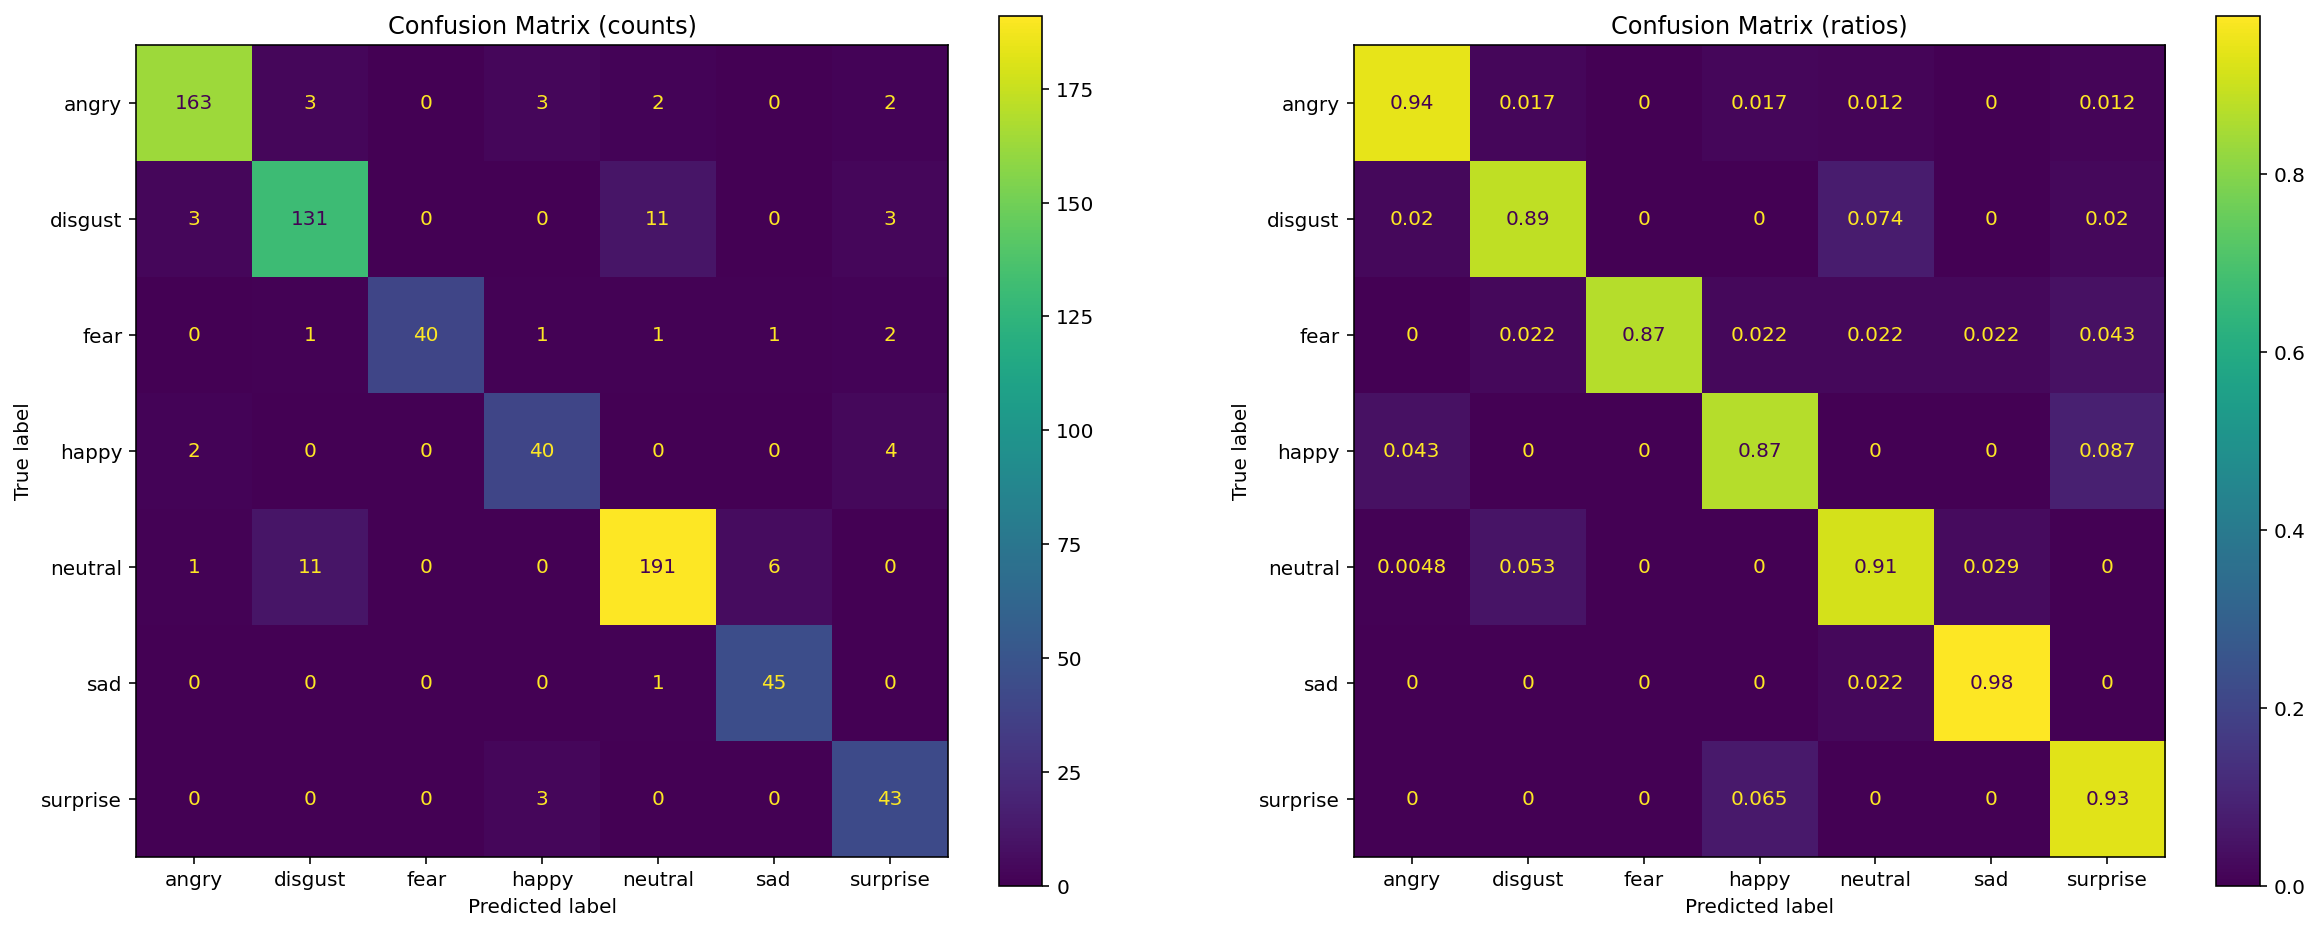

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute test set predictions
predictions = model.predict(X_te_rescaled)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.savefig("/content/drive/MyDrive/LY Project/dense_network_without_hidden_layers_confusion_matrices.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)

In [12]:
# Create model with hidden layers
model_hl = Sequential()

# Hidden layer 1
model_hl.add(Dense(units=256, 
                activation=activations.relu,
                input_dim=90,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Hidden layer 2
model_hl.add(Dense(units=64,
                activation=activations.relu,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Output layer
model_hl.add(Dense(units=7,
                activation=activations.softmax,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0),
                kernel_regularizer=tf.keras.regularizers.l2(0.001)))

# Network summary
model_hl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               23296     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 40,199
Trainable params: 40,199
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Define loss function, optimizer and metrics to track during training
model_hl.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])

# Fit model
history = model_hl.fit(
    x=X_tr_rescaled,
    y=y_tr,
    validation_split=0.3,             # Split training/validation sets by 70/30 ratio at each epoch
    class_weight=class_weights,       # Apply class weights
    callbacks=[earlystopping_cb],     # Apply earlystopping callback
    batch_size=32,                    # 32 samples for each batch
    epochs=1000,                       # Running 100 epochs
    shuffle=True,                     # Shuffle training data at each epoch
)



Epoch 1/1000
141/141 [==============================] - 1s 5ms/step - loss: 1.6716 - acc: 0.4911 - val_loss: 1.3324 - val_acc: 0.6969
Epoch 2/1000
141/141 [==============================] - 1s 4ms/step - loss: 1.0341 - acc: 0.7657 - val_loss: 0.9896 - val_acc: 0.8080
Epoch 3/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.8314 - acc: 0.8385 - val_loss: 0.8528 - val_acc: 0.8396
Epoch 4/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.7290 - acc: 0.8703 - val_loss: 0.7688 - val_acc: 0.8604
Epoch 5/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.6693 - acc: 0.8883 - val_loss: 0.7158 - val_acc: 0.8786
Epoch 6/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.6268 - acc: 0.8990 - val_loss: 0.6750 - val_acc: 0.8864
Epoch 7/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.5954 - acc: 0.9097 - val_loss: 0.6501 - val_acc: 0.8931
Epoch 8/1000
141/141 [==============================] - 1s 4ms

In [14]:
hist_df1 = pd.DataFrame(history.history) 
hist_df1.to_csv("/content/drive/MyDrive/LY Project/dense_network_with_two_hidden_layers_history.csv")

model_hl.save_weights("/content/drive/MyDrive/LY Project/dense_network_with_two_hidden_layers_weights.h5")

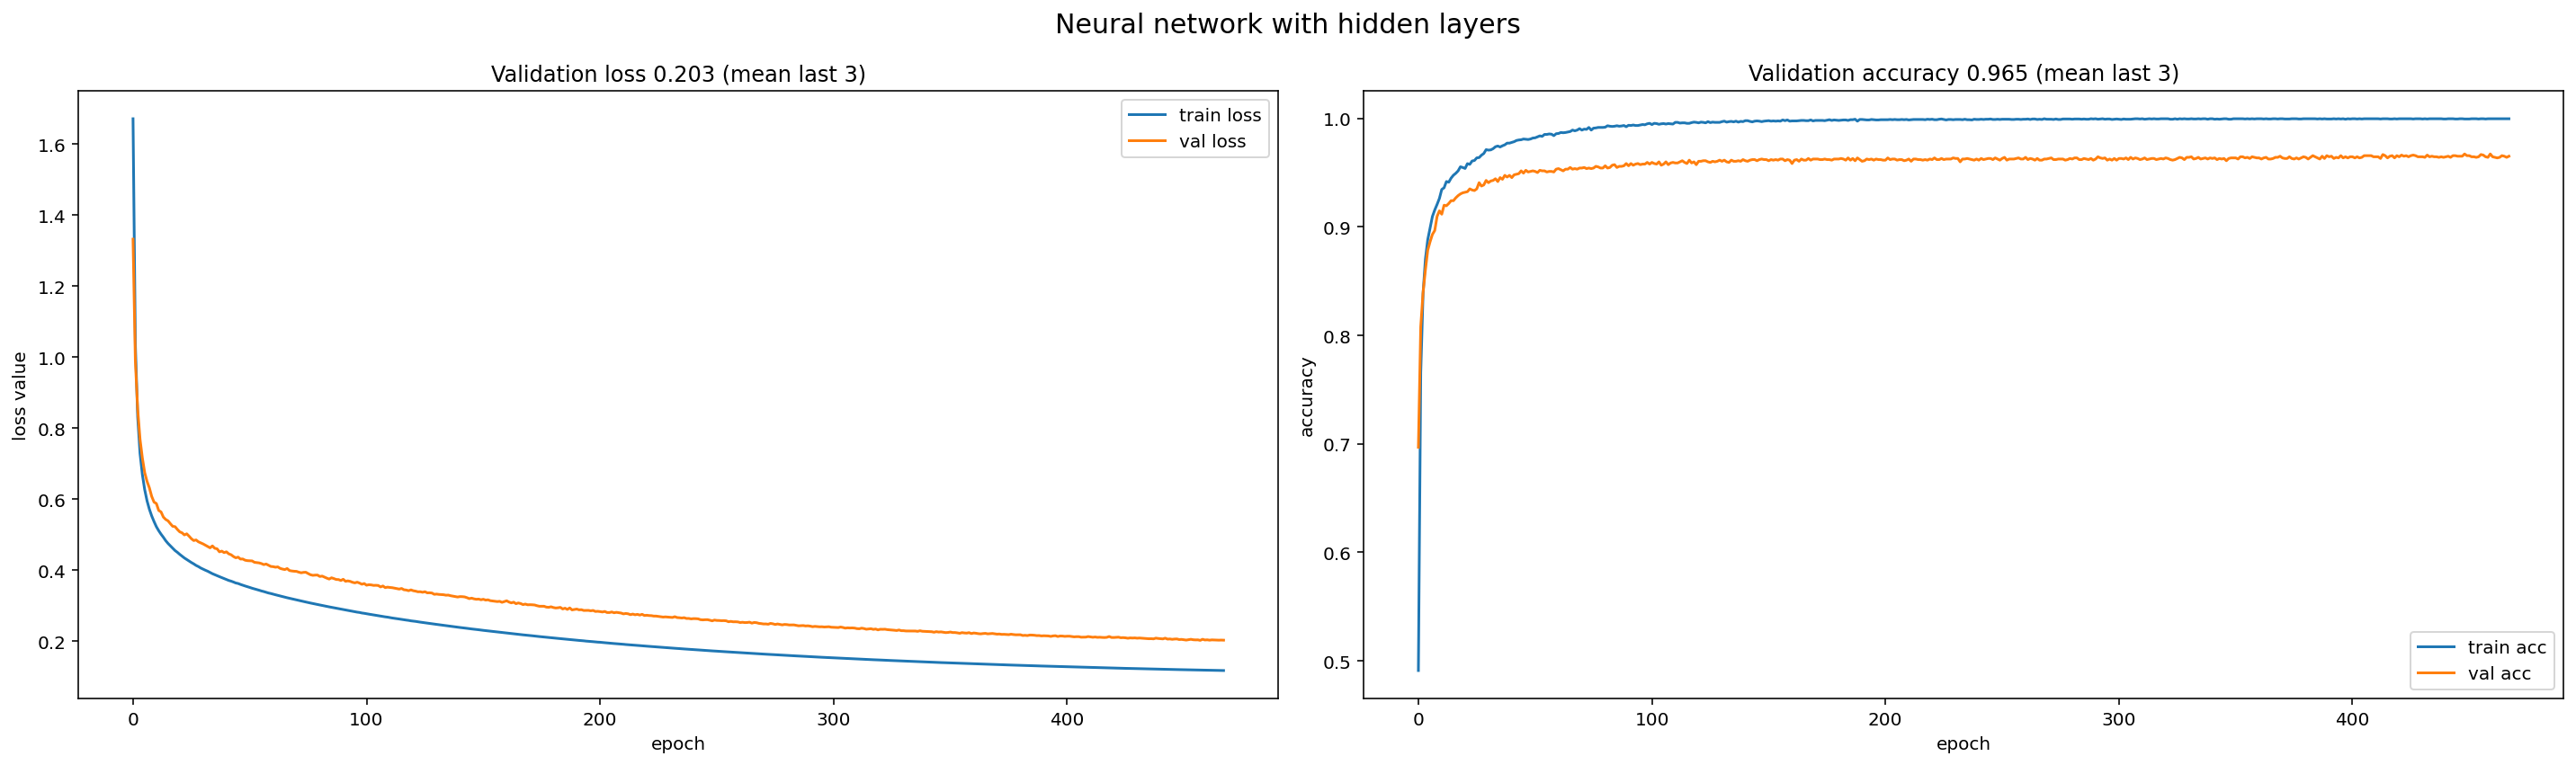

In [15]:
# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plt.suptitle('Neural network with hidden layers', size=15)

# Plot accuracy values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/LY Project/dense_network_with_two_hidden_layers_training_curves.png")
plt.show()

In [16]:
(test_loss, test_accuracy) = model_hl.evaluate(X_te_rescaled, y_te, batch_size=32)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

23/23 [==============================] - 0s 2ms/step - loss: 0.2060 - acc: 0.9622
Test loss: 0.21
Test accuracy: 96.22%


23/23 [==============================] - 0s 1ms/step


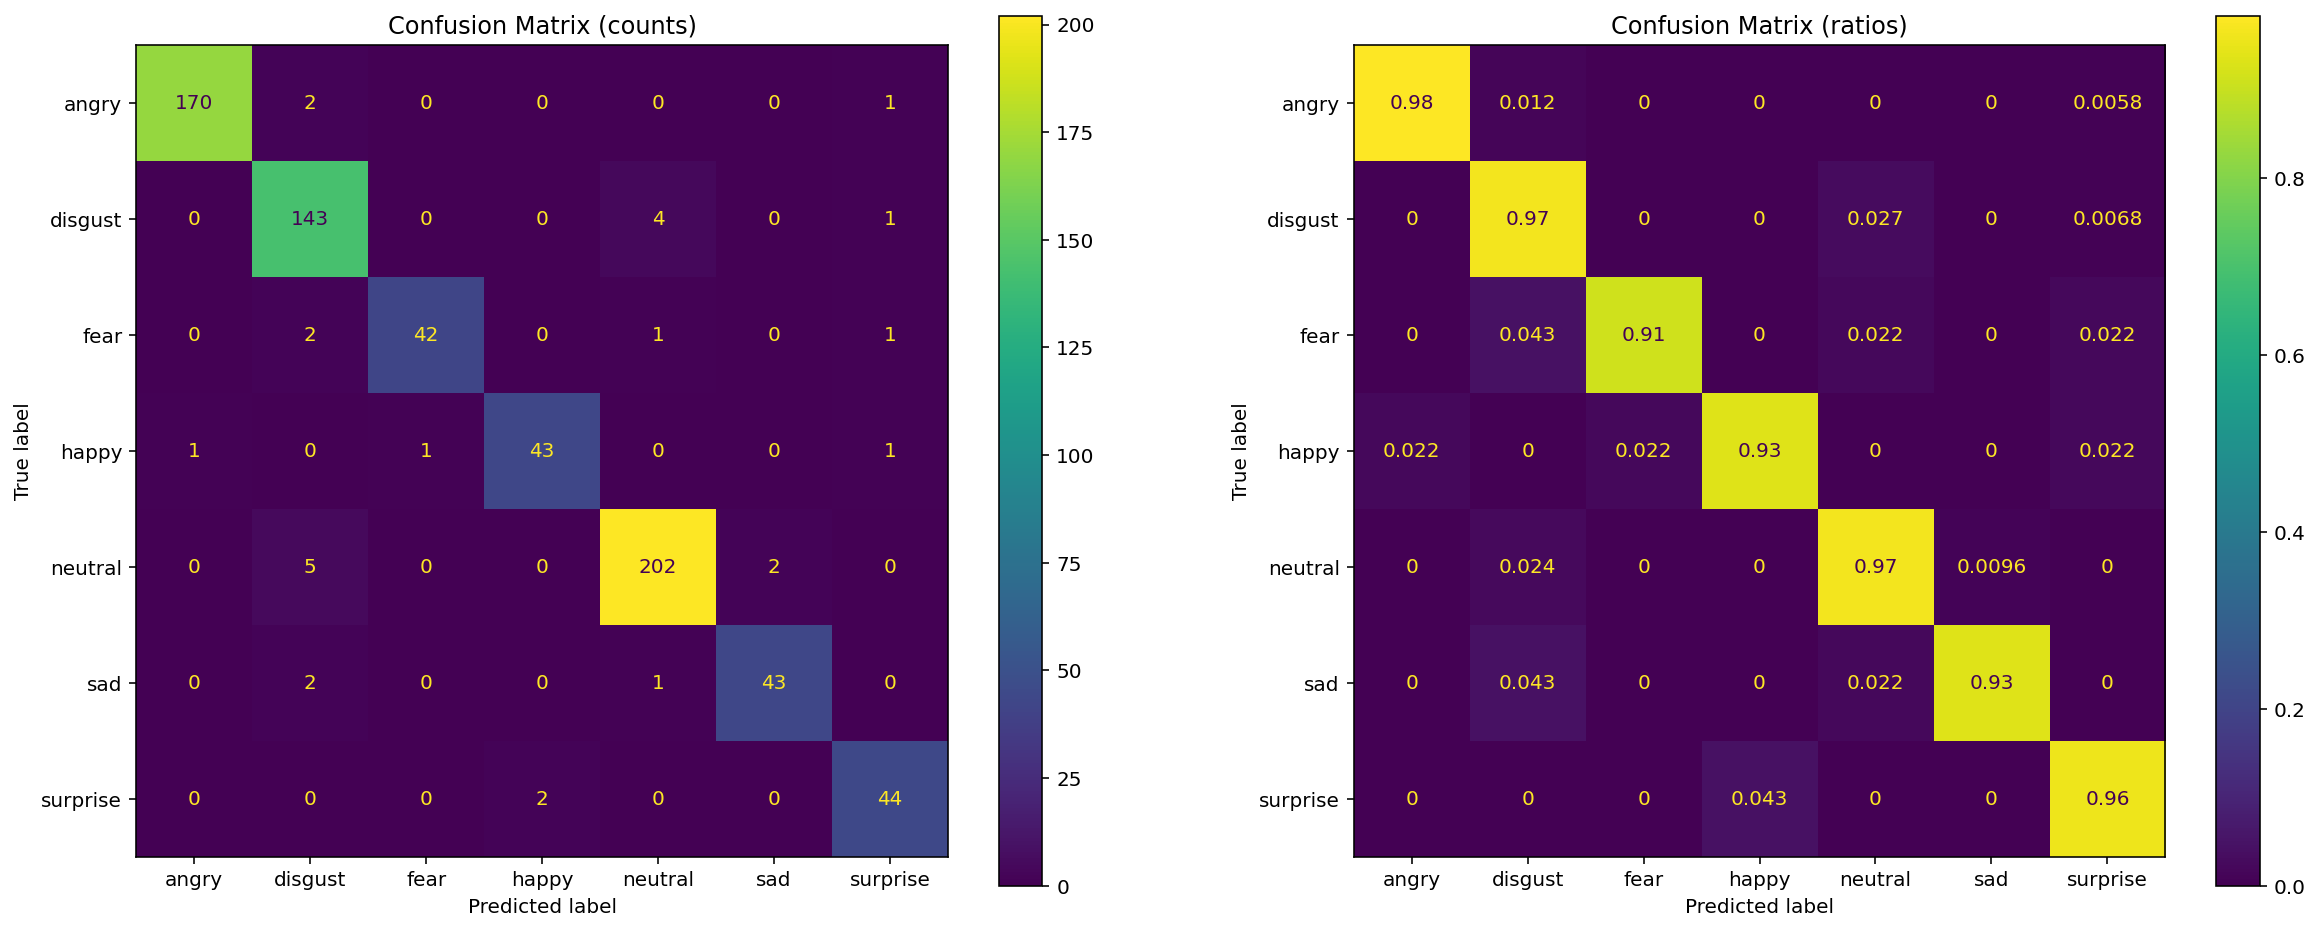

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute test set predictions
predictions = model_hl.predict(X_te_rescaled)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)
    plt.savefig("/content/drive/MyDrive/LY Project/dense_network_with_two_hidden_layers_confusion_matrices.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)